In [1]:
from datetime import timedelta, datetime, timezone
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from utils import \
    get_prices, \
    plot_heatmap, \
    plot_errors_hist, \
    plot_estimators_hist, \
    plot_returns_and_filter, \
    load_results, \
    apply_kalman_filter, \
    compute_features, \
    load_data, \
    resample_data, \
    calculate_thetas

In [2]:
start_time_ = datetime(2019, 11, 27, tzinfo=timezone.utc)
end_time_ = datetime(2020, 2, 4, tzinfo=timezone.utc)

# duration = timedelta(days=int((end_time_ - start_time_).days))
# df_ = get_prices('btc', 'usdt', start_time_, duration=duration, proxy_port='8815', verbose=2)

df_ = load_data(start_time_, end_time_)

timeframe = timedelta(minutes=5)
df = resample_data(df_, timeframe, start_time_, end_time_)
df

,Open,High,Low,Close,Volume,Value,No. Trades,Taker Buy Volume,Taker Buy Value,Average Price,Average Price Change
2019-11-27 00:00:00,7154.75,7164.59,7140.54,7162.89,164.200264,1.174323e+06,1234,103.771014,742217.277131,7151.772051,NaN
2019-11-27 00:05:00,7164.4,7169.00,7152.92,7157.86,115.531698,8.275534e+05,904,73.404774,525826.737982,7162.998797,0.001570
2019-11-27 00:10:00,7157.32,7160.19,7144.93,7151.68,112.780186,8.065373e+05,914,57.210353,409185.537990,7151.409684,-0.001618
2019-11-27 00:15:00,7152.16,7152.20,7138.93,7142.66,157.903923,1.128197e+06,833,70.538540,503984.524916,7144.828939,-0.000920
2019-11-27 00:20:00,7142.63,7148.81,7138.94,7146.63,71.999481,5.143852e+05,638,42.162902,301241.148857,7144.290518,-0.000075
...,...,...,...,...,...,...,...,...,...,...,...
2020-02-03 23:35:00,9298.38,9300.35,9277.07,9294.66,148.543688,1.379950e+06,1348,82.834562,769549.767916,9289.856558,-0.000593
2020-02-03 23:40:00,9294.66,9307.69,9294.01,9304.29,90.220836,8.392079e+05,908,64.413847,599153.526012,9301.708836,0.001276
2020-02-03 23:45:00,9304,9319.99,9295.98,9316.82,139.875918,1.301847e+06,1874,68.115588,633991.892739,9307.156778,0.000586
2020-02-03 23:50:00,9316.15,9316.88,9303.73,9306.52,95.824739,8.921500e+05,1331,45.580965,424366.578549,9310.226182,0.000330


# Validation to find best memory size m

In [3]:
# from scipy.stats import pearsonr
# tmp = [(1., 0), ]
# for i in range(360):
#     if i == 0:
#         x = (df['Average Price'].shift(-1) / df['Average Price'] - 1) * 100 * RETURN_SCALE
#     else:
#         y = (df['Average Price'].shift(-i-1) / df['Average Price'] - 1) * 100 * RETURN_SCALE
#         intersection = sorted(list(set(x.dropna().index).intersection(set(y.dropna().index))))
#         tmp.append(pearsonr(x.loc[intersection], y.loc[intersection]))
# tmp = np.array(tmp)

In [4]:
# %matplotlib inline
# plt.figure(figsize=(10, 3), dpi=120)
# plt.plot(np.log2(tmp[:, 0]))
# plt.title('BTC Price Change Memory')
# txt = "correlation diagram (in binary logarithmic scale) of BTC price return with cummulative price return up to some future point"
# plt.gcf().text(0.5, -0.1, txt, wrap=False, horizontalalignment='center', fontsize=8)
# plt.xlabel('time elapsed (minutes)')
# plt.ylabel('correlation (logarithmic)')
# plt.xticks(np.arange(25) * 15, fontsize=5)
# plt.yticks(np.arange(0, -5, -1))
# plt.grid()
# for i in range(-1, -5, -1):
#     point = np.where(np.log2(tmp[:, 0]) >= i)[0][-1]
#     plt.scatter(point, np.log2(tmp[point, 0]), marker='x', label=str(point))
# plt.legend()
# plt.savefig("Correlation.png")
# plt.show()

# Linear Model without Control

In [5]:
# t = np.bincount(np.sign(results['Prediction']) == np.sign(results['Reality']))
# print(t[1] / (t[0]+t[1]) * 100)
# print('STANDARD ERRORS')
# for c_label in ['Prediction', 'Measurement']:
#     print('  > {:13s}{:.5f}'.format(c_label + ':', (results[c_label] - results['Reality']).std()))
# print('  > {:13s}{:.5f}'.format('Reality:', (results['Reality']-df['Average Price Change'].loc[indices].values).std()))

In [6]:
# stds = [[], []]
# results = None
# for i, m in enumerate([15, 60]):
#     for k in np.arange(1, 16)*64 + 63:
#         results = pd.read_csv(f'data/linear_model_without_control[k={k},m={m}]')
#         tmp = results['Prediction'].astype(float) - results['Reality'].astype(float)
#         stds[i].append(tmp.std())

# plt.figure(figsize=(10, 6), dpi=300)

# plt.plot(range(127, 1087, 64), stds[0], label=r'$\hat{X}_n = \Sigma_{i=0}^{15}\ \theta_i X_{n-1-i}$')
# plt.plot(range(127, 1087, 64), stds[1], label=r'$\hat{X}_n = \Sigma_{i=0}^{60}\ \theta_i X_{n-1-i}$')

# tmp = results['Reality'].astype(float)
# plt.plot([127, 1023], [(tmp-tmp.shift(1)).dropna().std(), (tmp-tmp.shift(1)).dropna().std()], label=r'$\hat{X}_n = \hat{X}_{n-1}$')
# plt.axhline(tmp.std(), label=r'$\hat{X}_n = 0$', linestyle=':')

# plt.legend()
# plt.title('Validation for Choosing Best k')
# plt.ylabel(r'$MSE(\hat{X_n}, X_n)$')
# plt.xlabel('k')

# plt.savefig('plots/best_k.png')
# plt.show()

In [7]:
title, k, m = 'Linear Model without Control', 511, 15
# calculate_thetas(df, title, k, m)

,Prediction,Measurement,Model Noise Bias,Reality,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
2019-12-01 00:00:00,-0.000151194,-0.000246313,-2.4646e-18,-0.001031,0.113763,0.045307,0.061947,-0.123987,-0.057214,-0.016974,0.145529,-0.103940,-0.073365,0.030542,0.075338,0.003971,-0.139944,-0.003650,0.117332,0.000019
2019-12-01 00:05:00,-0.000117318,-0.000687904,1.3579e-20,-0.002840,0.114201,0.044479,0.061361,-0.122683,-0.058039,-0.015767,0.144616,-0.104022,-0.073745,0.031034,0.075203,0.004110,-0.140070,-0.004465,0.118201,0.000018
2019-12-01 00:10:00,-0.000125821,-0.000604879,9.58681e-18,-0.000342,0.116022,0.047748,0.058770,-0.124057,-0.054496,-0.017606,0.147943,-0.106754,-0.073489,0.029764,0.076626,0.003759,-0.139290,-0.006270,0.119223,0.000014
2019-12-01 00:15:00,0.000311569,1.39134e-05,-5.2483e-18,-0.001469,0.116085,0.047689,0.059321,-0.124266,-0.055229,-0.016816,0.147316,-0.105774,-0.074319,0.029467,0.076769,0.004235,-0.139593,-0.006533,0.119541,0.000015
2019-12-01 00:20:00,0.000301678,-0.00110829,-6.9321e-18,-0.000018,0.116631,0.050341,0.058950,-0.122899,-0.057035,-0.015903,0.148577,-0.105632,-0.074382,0.029459,0.077731,0.002833,-0.139741,-0.005788,0.119219,0.000009
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-31 23:35:00,0.000183365,0.00107738,7.08147e-18,0.000035,0.038587,-0.118999,0.009617,0.007802,0.004277,-0.000412,-0.029143,0.007553,-0.007132,-0.004534,0.070324,-0.148429,0.087161,0.003176,-0.020872,0.000016
2020-01-31 23:40:00,-0.000201702,0.000342392,5.49951e-19,-0.003235,0.038253,-0.119055,0.009686,0.007908,0.004780,-0.000885,-0.029006,0.007405,-0.007142,-0.003910,0.070025,-0.148345,0.086726,0.003385,-0.020976,0.000015
2020-01-31 23:45:00,0.000101608,-0.000170122,-7.23084e-18,-0.001554,0.038810,-0.127748,0.009414,0.009480,0.006578,0.006896,-0.036820,0.008296,-0.012538,-0.000085,0.076440,-0.150228,0.087039,-0.001283,-0.019420,0.000010
2020-01-31 23:50:00,0.000521479,-0.000945324,1.96217e-18,0.000073,0.044083,-0.126859,0.006420,0.009710,0.007397,0.007688,-0.033681,0.005049,-0.012874,-0.003950,0.080199,-0.149852,0.088678,-0.002202,-0.019548,0.000008


In [8]:
results = load_results(title, k, m)
results

,Prediction,Measurement,Model Noise Bias,Reality,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
2019-12-01 00:00:00,-0.000151,-0.000246,-2.464597e-18,-0.001031,0.113763,0.045307,0.061947,-0.123987,-0.057214,-0.016974,0.145529,-0.103940,-0.073365,0.030542,0.075338,0.003971,-0.139944,-0.003650,0.117332,0.000019
2019-12-01 00:05:00,-0.000117,-0.000688,1.357905e-20,-0.002840,0.114201,0.044479,0.061361,-0.122683,-0.058039,-0.015767,0.144616,-0.104022,-0.073745,0.031034,0.075203,0.004110,-0.140070,-0.004465,0.118201,0.000018
2019-12-01 00:10:00,-0.000126,-0.000605,9.586808e-18,-0.000342,0.116022,0.047748,0.058770,-0.124057,-0.054496,-0.017606,0.147943,-0.106754,-0.073489,0.029764,0.076626,0.003759,-0.139290,-0.006270,0.119223,0.000014
2019-12-01 00:15:00,0.000312,0.000014,-5.248302e-18,-0.001469,0.116085,0.047689,0.059321,-0.124266,-0.055229,-0.016816,0.147316,-0.105774,-0.074319,0.029467,0.076769,0.004235,-0.139593,-0.006533,0.119541,0.000015
2019-12-01 00:20:00,0.000302,-0.001108,-6.932104e-18,-0.000018,0.116631,0.050341,0.058950,-0.122899,-0.057035,-0.015903,0.148577,-0.105632,-0.074382,0.029459,0.077731,0.002833,-0.139741,-0.005788,0.119219,0.000009
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-31 23:35:00,0.000183,0.001077,7.081474e-18,0.000035,0.038587,-0.118999,0.009617,0.007802,0.004277,-0.000412,-0.029143,0.007553,-0.007132,-0.004534,0.070324,-0.148429,0.087161,0.003176,-0.020872,0.000016
2020-01-31 23:40:00,-0.000202,0.000342,5.499515e-19,-0.003235,0.038253,-0.119055,0.009686,0.007908,0.004780,-0.000885,-0.029006,0.007405,-0.007142,-0.003910,0.070025,-0.148345,0.086726,0.003385,-0.020976,0.000015
2020-01-31 23:45:00,0.000102,-0.000170,-7.230843e-18,-0.001554,0.038810,-0.127748,0.009414,0.009480,0.006578,0.006896,-0.036820,0.008296,-0.012538,-0.000085,0.076440,-0.150228,0.087039,-0.001283,-0.019420,0.000010
2020-01-31 23:50:00,0.000521,-0.000945,1.962173e-18,0.000073,0.044083,-0.126859,0.006420,0.009710,0.007397,0.007688,-0.033681,0.005049,-0.012874,-0.003950,0.080199,-0.149852,0.088678,-0.002202,-0.019548,0.000008


In [9]:
apply_kalman_filter(results)
results

,Prediction,Measurement,Model Noise Bias,Reality,0,1,2,3,4,5,...,13,14,15,Measurement Residual,Prediction Residual,Measurement Residual Weighted Variance,Prediction Residual Weighted Variance,Kalman Gain,Estimate,Estimate Uncertainty
2019-12-01 00:00:00,-0.000151,-0.000246,-2.464597e-18,-0.001031,0.113763,0.045307,0.061947,-0.123987,-0.057214,-0.016974,...,-0.003650,0.117332,0.000019,0.000785,0.000880,NaN,NaN,NaN,NaN,NaN
2019-12-01 00:05:00,-0.000117,-0.000688,1.357905e-20,-0.002840,0.114201,0.044479,0.061361,-0.122683,-0.058039,-0.015767,...,-0.004465,0.118201,0.000018,0.002152,0.002722,NaN,NaN,NaN,NaN,NaN
2019-12-01 00:10:00,-0.000126,-0.000605,9.586808e-18,-0.000342,0.116022,0.047748,0.058770,-0.124057,-0.054496,-0.017606,...,-0.006270,0.119223,0.000014,-0.000263,0.000216,NaN,NaN,NaN,NaN,NaN
2019-12-01 00:15:00,0.000312,0.000014,-5.248302e-18,-0.001469,0.116085,0.047689,0.059321,-0.124266,-0.055229,-0.016816,...,-0.006533,0.119541,0.000015,0.001483,0.001781,NaN,NaN,NaN,NaN,NaN
2019-12-01 00:20:00,0.000302,-0.001108,-6.932104e-18,-0.000018,0.116631,0.050341,0.058950,-0.122899,-0.057035,-0.015903,...,-0.005788,0.119219,0.000009,-0.001090,0.000320,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-31 23:35:00,0.000183,0.001077,7.081474e-18,0.000035,0.038587,-0.118999,0.009617,0.007802,0.004277,-0.000412,...,0.003176,-0.020872,0.000016,0.001042,0.000148,0.000001,0.000002,0.554169,0.000679,7.268740e-07
2020-01-31 23:40:00,-0.000202,0.000342,5.499515e-19,-0.003235,0.038253,-0.119055,0.009686,0.007908,0.004780,-0.000885,...,0.003385,-0.020976,0.000015,0.003577,0.003033,0.000001,0.000002,0.563303,0.000105,8.439026e-07
2020-01-31 23:45:00,0.000102,-0.000170,-7.230843e-18,-0.001554,0.038810,-0.127748,0.009414,0.009480,0.006578,0.006896,...,-0.001283,-0.019420,0.000010,0.001383,0.001655,0.000002,0.000002,0.574659,-0.000055,8.746888e-07
2020-01-31 23:50:00,0.000521,-0.000945,1.962173e-18,0.000073,0.044083,-0.126859,0.006420,0.009710,0.007397,0.007688,...,-0.002202,-0.019548,0.000008,-0.001019,0.000448,0.000002,0.000002,0.565229,-0.000308,8.680162e-07


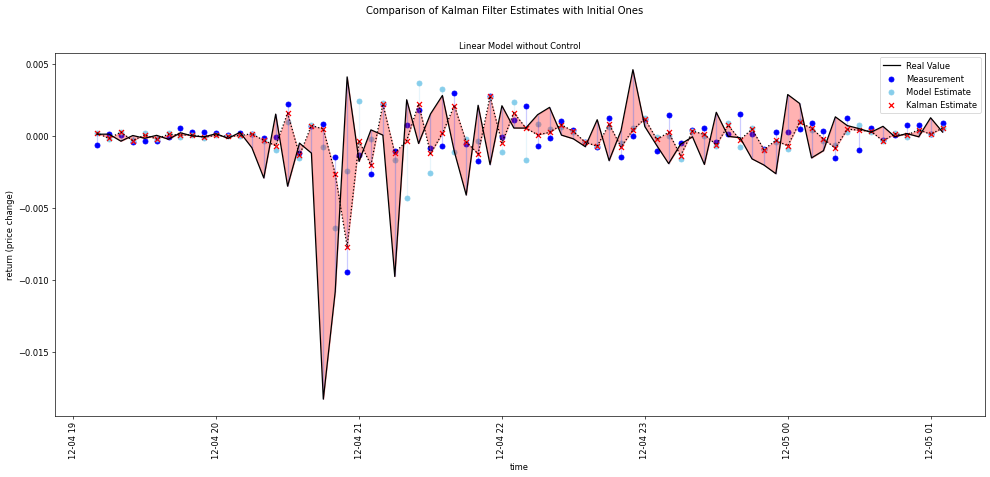

In [10]:
indices = results.index[np.arange(12*6) + int(288*3.8)]
plot_returns_and_filter(results, indices, title)

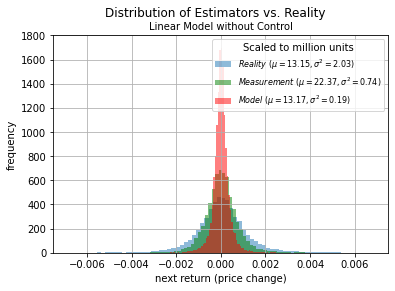

In [11]:
plot_estimators_hist(results, title)

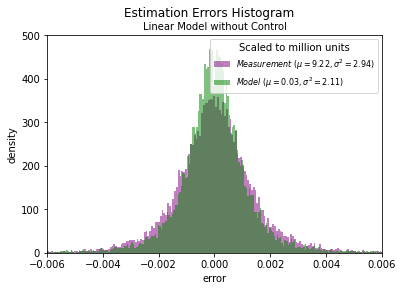

In [12]:
plot_errors_hist(results, title)

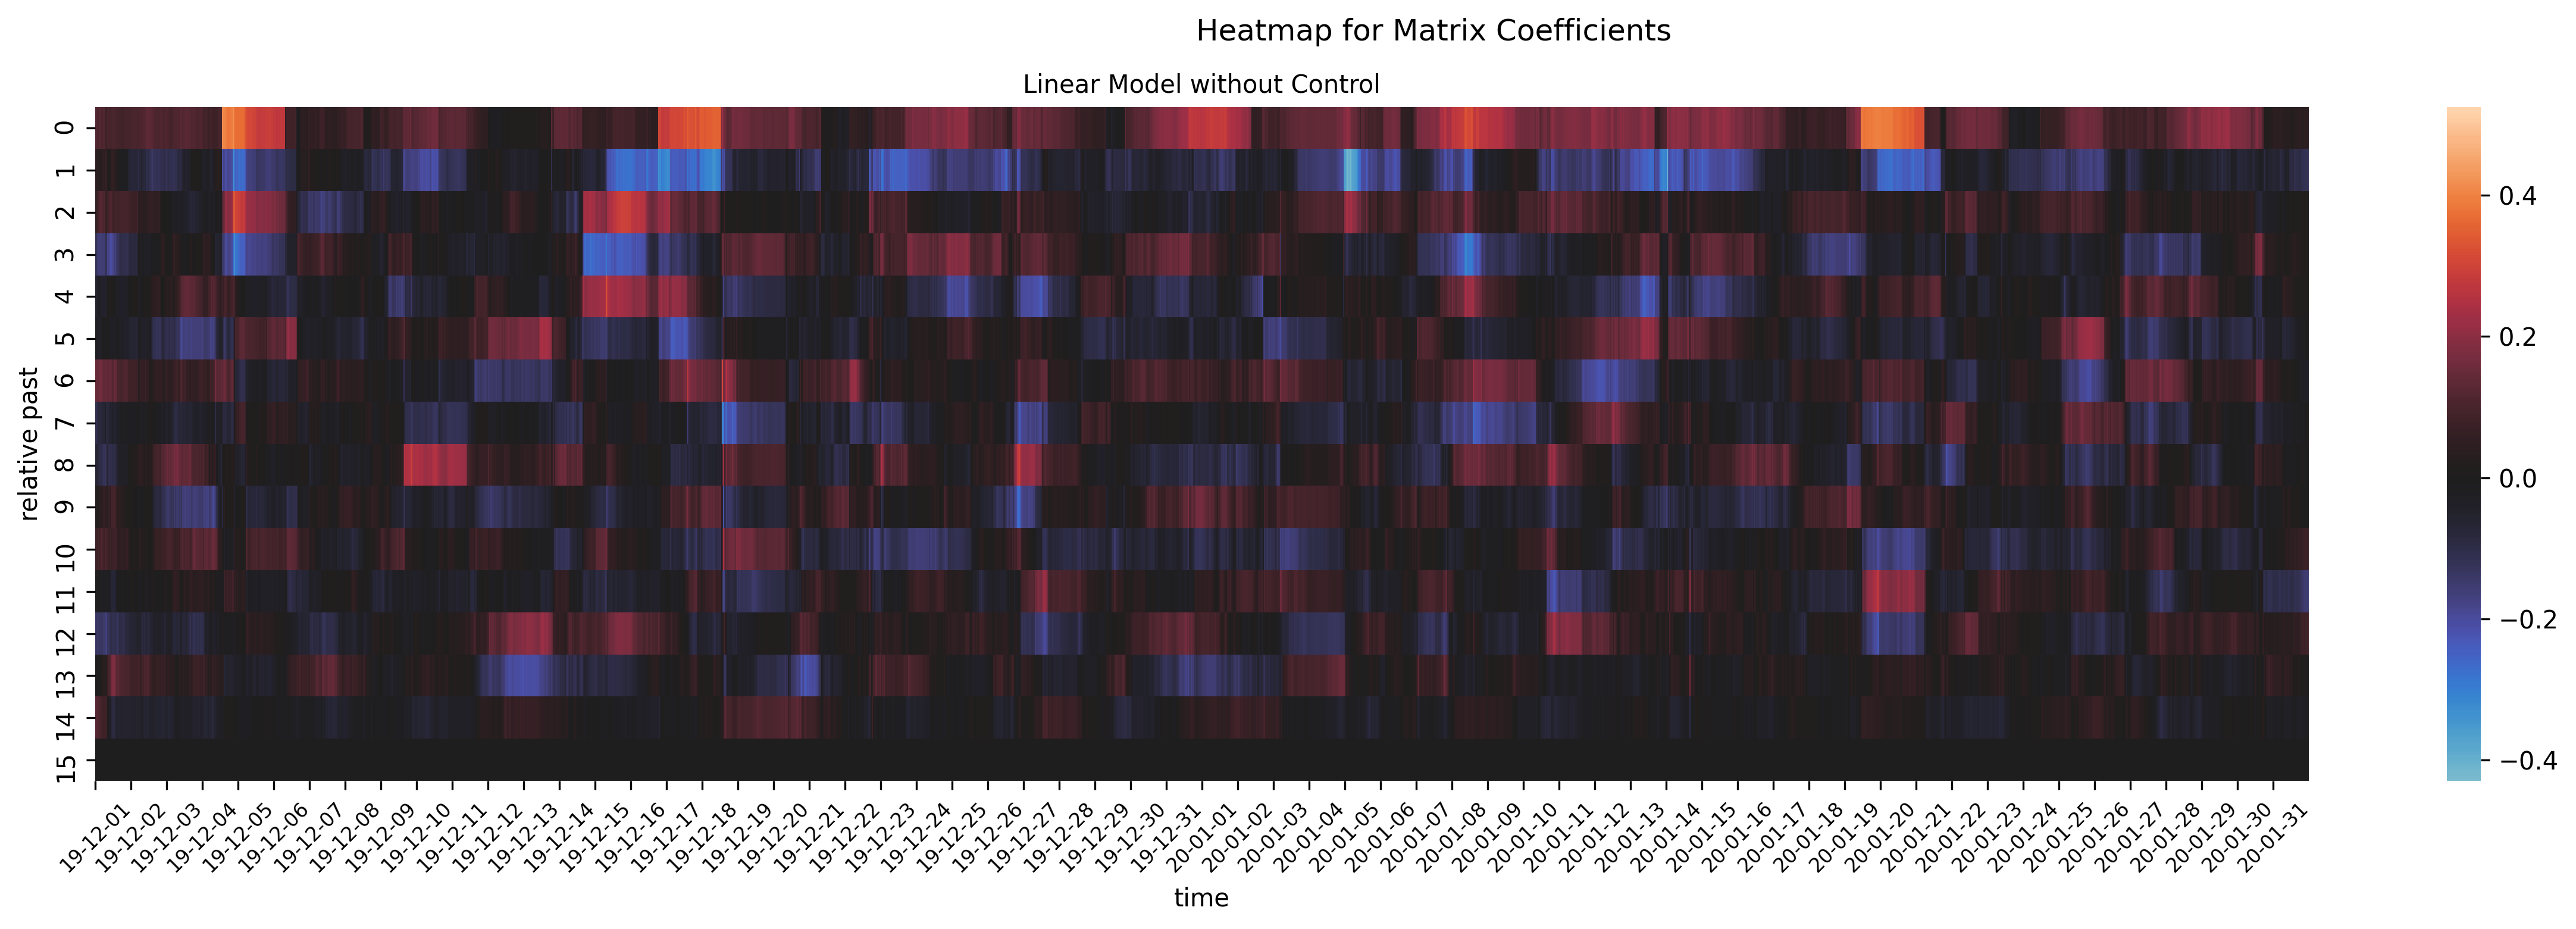

In [13]:
plot_heatmap(results[[f'{i}' for i in range(m+1)]], title)

# Linear Model with Control

In [14]:
features = compute_features(df)
features

,taker buy volume ratio,volume (1e3),volume change,trades number (1e3),trades number change,taker buy average spread (1e-3),taker sell average spread (1e-3)
2019-11-27 00:00:00,0.631978,0.164200,NaN,1.234,NaN,0.095183,-0.163451
2019-11-27 00:05:00,0.635365,0.115532,-0.296398,0.904,-0.267423,0.054070,-0.094216
2019-11-27 00:10:00,0.507273,0.112780,-0.023816,0.914,0.011062,0.124325,-0.127995
2019-11-27 00:15:00,0.446718,0.157904,0.400103,0.833,-0.088621,-0.002534,0.002046
2019-11-27 00:20:00,0.585600,0.071999,-0.544030,0.638,-0.234094,0.056861,-0.080352
...,...,...,...,...,...,...,...
2020-02-03 23:35:00,0.557644,0.148544,1.582849,1.348,0.829037,0.037126,-0.046801
2020-02-03 23:40:00,0.713958,0.090221,-0.392631,0.908,-0.326409,-0.008885,0.022178
2020-02-03 23:45:00,0.486972,0.139876,0.550373,1.874,1.063877,0.046432,-0.044074
2020-02-03 23:50:00,0.475670,0.095825,-0.314930,1.331,-0.289755,-0.005927,0.005377


In [17]:
s = len(features.columns)
title, k, m = 'Linear Model with Control', 511, 15
# calculate_thetas(df, title, k, m, features=features)

,Prediction,Measurement,Model Noise Bias,Reality,0,1,2,3,4,5,...,13,14,15,16,17,18,19,20,21,22
2019-12-01 00:00:00,-0.00034817,-0.000246313,-9.66149e-18,-0.001031,0.081466,0.060336,0.033408,-0.105543,-0.059328,-0.001182,...,0.008399,0.104942,-0.000098,0.001018,0.005554,-0.000052,-0.001060,0.000061,-0.000155,0.000669
2019-12-01 00:05:00,-2.3206e-06,-0.000687904,1.39185e-18,-0.002840,0.081567,0.059884,0.032804,-0.104443,-0.059973,-0.000314,...,0.008177,0.105365,-0.000105,0.001027,0.005544,-0.000050,-0.001057,0.000058,-0.000170,0.000659
2019-12-01 00:10:00,-0.000169572,-0.000604879,-3.51697e-18,-0.000342,0.083363,0.062959,0.030869,-0.106179,-0.056425,-0.002342,...,0.005729,0.106931,-0.000109,0.001024,0.005544,-0.000064,-0.001056,0.000068,-0.000137,0.000680
2019-12-01 00:15:00,0.000527591,1.39134e-05,-4.31678e-17,-0.001469,0.083442,0.063130,0.031046,-0.106180,-0.057021,-0.001837,...,0.005421,0.107214,-0.000107,0.001019,0.005522,-0.000064,-0.001051,0.000067,-0.000146,0.000682
2019-12-01 00:20:00,0.000376275,-0.00110829,7.79437e-18,-0.000018,0.083694,0.065391,0.031427,-0.105083,-0.059084,-0.000504,...,0.006610,0.106758,-0.000121,0.001040,0.005546,-0.000068,-0.001059,0.000082,-0.000130,0.000656
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-31 23:35:00,0.000403565,0.00107738,1.12299e-17,0.000035,0.053721,-0.126910,0.012412,-0.001140,-0.006976,0.019698,...,-0.008275,-0.000946,-0.000411,0.001722,0.003928,-0.000227,-0.000676,0.000281,0.000760,0.002174
2020-01-31 23:40:00,-0.000292443,0.000342392,-6.82822e-17,-0.003235,0.054345,-0.126728,0.012589,-0.001052,-0.006791,0.019076,...,-0.008396,-0.001065,-0.000411,0.001731,0.003955,-0.000233,-0.000682,0.000301,0.000775,0.002194
2020-01-31 23:45:00,-0.000619061,-0.000170122,-7.54452e-17,-0.001554,0.053900,-0.134875,0.013178,0.000591,-0.004917,0.026452,...,-0.011896,0.000145,-0.000466,0.001807,0.003897,-0.000222,-0.000670,0.000279,0.000843,0.002242
2020-01-31 23:50:00,0.000119586,-0.000945324,-5.72289e-17,0.000073,0.058197,-0.135719,0.012799,0.000556,-0.004595,0.027464,...,-0.011643,0.001056,-0.000458,0.001813,0.004010,-0.000235,-0.000689,0.000286,0.000891,0.002252


In [18]:
results = load_results(title, k, m)
results

,Prediction,Measurement,Model Noise Bias,Reality,0,1,2,3,4,5,...,13,14,15,16,17,18,19,20,21,22
2019-12-01 00:00:00,-0.000348,-0.000246,-9.661493e-18,-0.001031,0.081466,0.060336,0.033408,-0.105543,-0.059328,-0.001182,...,0.008399,0.104942,-0.000098,0.001018,0.005554,-0.000052,-0.001060,0.000061,-0.000155,0.000669
2019-12-01 00:05:00,-0.000002,-0.000688,1.391852e-18,-0.002840,0.081567,0.059884,0.032804,-0.104443,-0.059973,-0.000314,...,0.008177,0.105365,-0.000105,0.001027,0.005544,-0.000050,-0.001057,0.000058,-0.000170,0.000659
2019-12-01 00:10:00,-0.000170,-0.000605,-3.516974e-18,-0.000342,0.083363,0.062959,0.030869,-0.106179,-0.056425,-0.002342,...,0.005729,0.106931,-0.000109,0.001024,0.005544,-0.000064,-0.001056,0.000068,-0.000137,0.000680
2019-12-01 00:15:00,0.000528,0.000014,-4.316780e-17,-0.001469,0.083442,0.063130,0.031046,-0.106180,-0.057021,-0.001837,...,0.005421,0.107214,-0.000107,0.001019,0.005522,-0.000064,-0.001051,0.000067,-0.000146,0.000682
2019-12-01 00:20:00,0.000376,-0.001108,7.794374e-18,-0.000018,0.083694,0.065391,0.031427,-0.105083,-0.059084,-0.000504,...,0.006610,0.106758,-0.000121,0.001040,0.005546,-0.000068,-0.001059,0.000082,-0.000130,0.000656
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-31 23:35:00,0.000404,0.001077,1.122987e-17,0.000035,0.053721,-0.126910,0.012412,-0.001140,-0.006976,0.019698,...,-0.008275,-0.000946,-0.000411,0.001722,0.003928,-0.000227,-0.000676,0.000281,0.000760,0.002174
2020-01-31 23:40:00,-0.000292,0.000342,-6.828225e-17,-0.003235,0.054345,-0.126728,0.012589,-0.001052,-0.006791,0.019076,...,-0.008396,-0.001065,-0.000411,0.001731,0.003955,-0.000233,-0.000682,0.000301,0.000775,0.002194
2020-01-31 23:45:00,-0.000619,-0.000170,-7.544519e-17,-0.001554,0.053900,-0.134875,0.013178,0.000591,-0.004917,0.026452,...,-0.011896,0.000145,-0.000466,0.001807,0.003897,-0.000222,-0.000670,0.000279,0.000843,0.002242
2020-01-31 23:50:00,0.000120,-0.000945,-5.722890e-17,0.000073,0.058197,-0.135719,0.012799,0.000556,-0.004595,0.027464,...,-0.011643,0.001056,-0.000458,0.001813,0.004010,-0.000235,-0.000689,0.000286,0.000891,0.002252


In [19]:
apply_kalman_filter(results)
results

,Prediction,Measurement,Model Noise Bias,Reality,0,1,2,3,4,5,...,20,21,22,Measurement Residual,Prediction Residual,Measurement Residual Weighted Variance,Prediction Residual Weighted Variance,Kalman Gain,Estimate,Estimate Uncertainty
2019-12-01 00:00:00,-0.000348,-0.000246,-9.661493e-18,-0.001031,0.081466,0.060336,0.033408,-0.105543,-0.059328,-0.001182,...,0.000061,-0.000155,0.000669,0.000785,0.000683,NaN,NaN,NaN,NaN,NaN
2019-12-01 00:05:00,-0.000002,-0.000688,1.391852e-18,-0.002840,0.081567,0.059884,0.032804,-0.104443,-0.059973,-0.000314,...,0.000058,-0.000170,0.000659,0.002152,0.002837,NaN,NaN,NaN,NaN,NaN
2019-12-01 00:10:00,-0.000170,-0.000605,-3.516974e-18,-0.000342,0.083363,0.062959,0.030869,-0.106179,-0.056425,-0.002342,...,0.000068,-0.000137,0.000680,-0.000263,0.000173,NaN,NaN,NaN,NaN,NaN
2019-12-01 00:15:00,0.000528,0.000014,-4.316780e-17,-0.001469,0.083442,0.063130,0.031046,-0.106180,-0.057021,-0.001837,...,0.000067,-0.000146,0.000682,0.001483,0.001997,NaN,NaN,NaN,NaN,NaN
2019-12-01 00:20:00,0.000376,-0.001108,7.794374e-18,-0.000018,0.083694,0.065391,0.031427,-0.105083,-0.059084,-0.000504,...,0.000082,-0.000130,0.000656,-0.001090,0.000395,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-31 23:35:00,0.000404,0.001077,1.122987e-17,0.000035,0.053721,-0.126910,0.012412,-0.001140,-0.006976,0.019698,...,0.000281,0.000760,0.002174,0.001042,0.000368,0.000001,0.000002,0.565476,0.000785,7.417045e-07
2020-01-31 23:40:00,-0.000292,0.000342,-6.828225e-17,-0.003235,0.054345,-0.126728,0.012589,-0.001052,-0.006791,0.019076,...,0.000301,0.000775,0.002194,0.003577,0.002942,0.000001,0.000002,0.518469,0.000037,7.767356e-07
2020-01-31 23:45:00,-0.000619,-0.000170,-7.544519e-17,-0.001554,0.053900,-0.134875,0.013178,0.000591,-0.004917,0.026452,...,0.000279,0.000843,0.002242,0.001383,0.000935,0.000002,0.000002,0.516889,-0.000387,7.867559e-07
2020-01-31 23:50:00,0.000120,-0.000945,-5.722890e-17,0.000073,0.058197,-0.135719,0.012799,0.000556,-0.004595,0.027464,...,0.000286,0.000891,0.002252,-0.001019,0.000046,0.000002,0.000002,0.515000,-0.000429,7.908808e-07


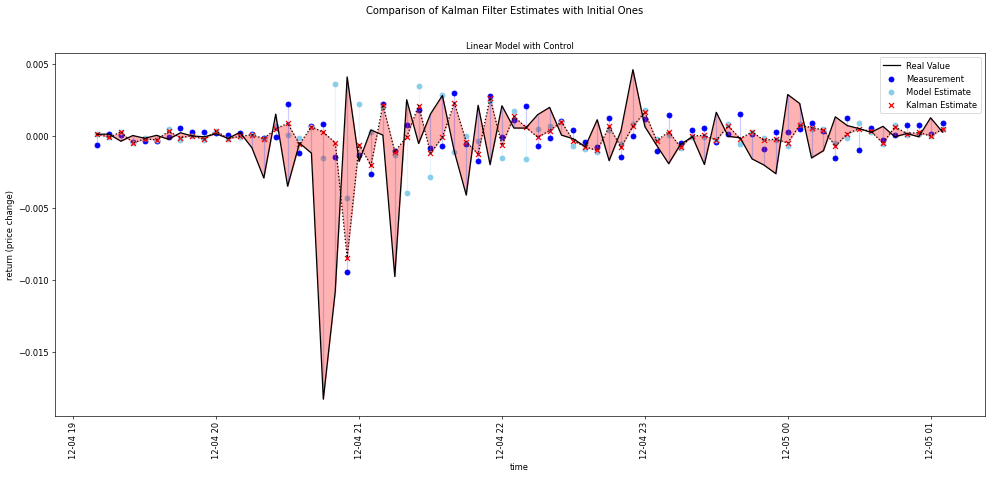

In [20]:
indices = results.index[np.arange(12*6) + int(288*3.8)]
plot_returns_and_filter(results, indices, title)

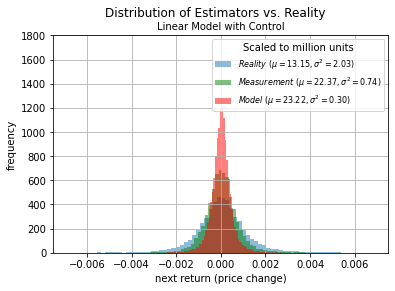

In [21]:
plot_estimators_hist(results, title)

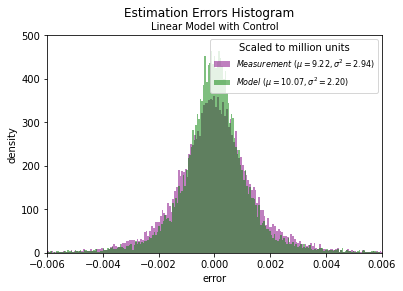

In [22]:
plot_errors_hist(results, title)

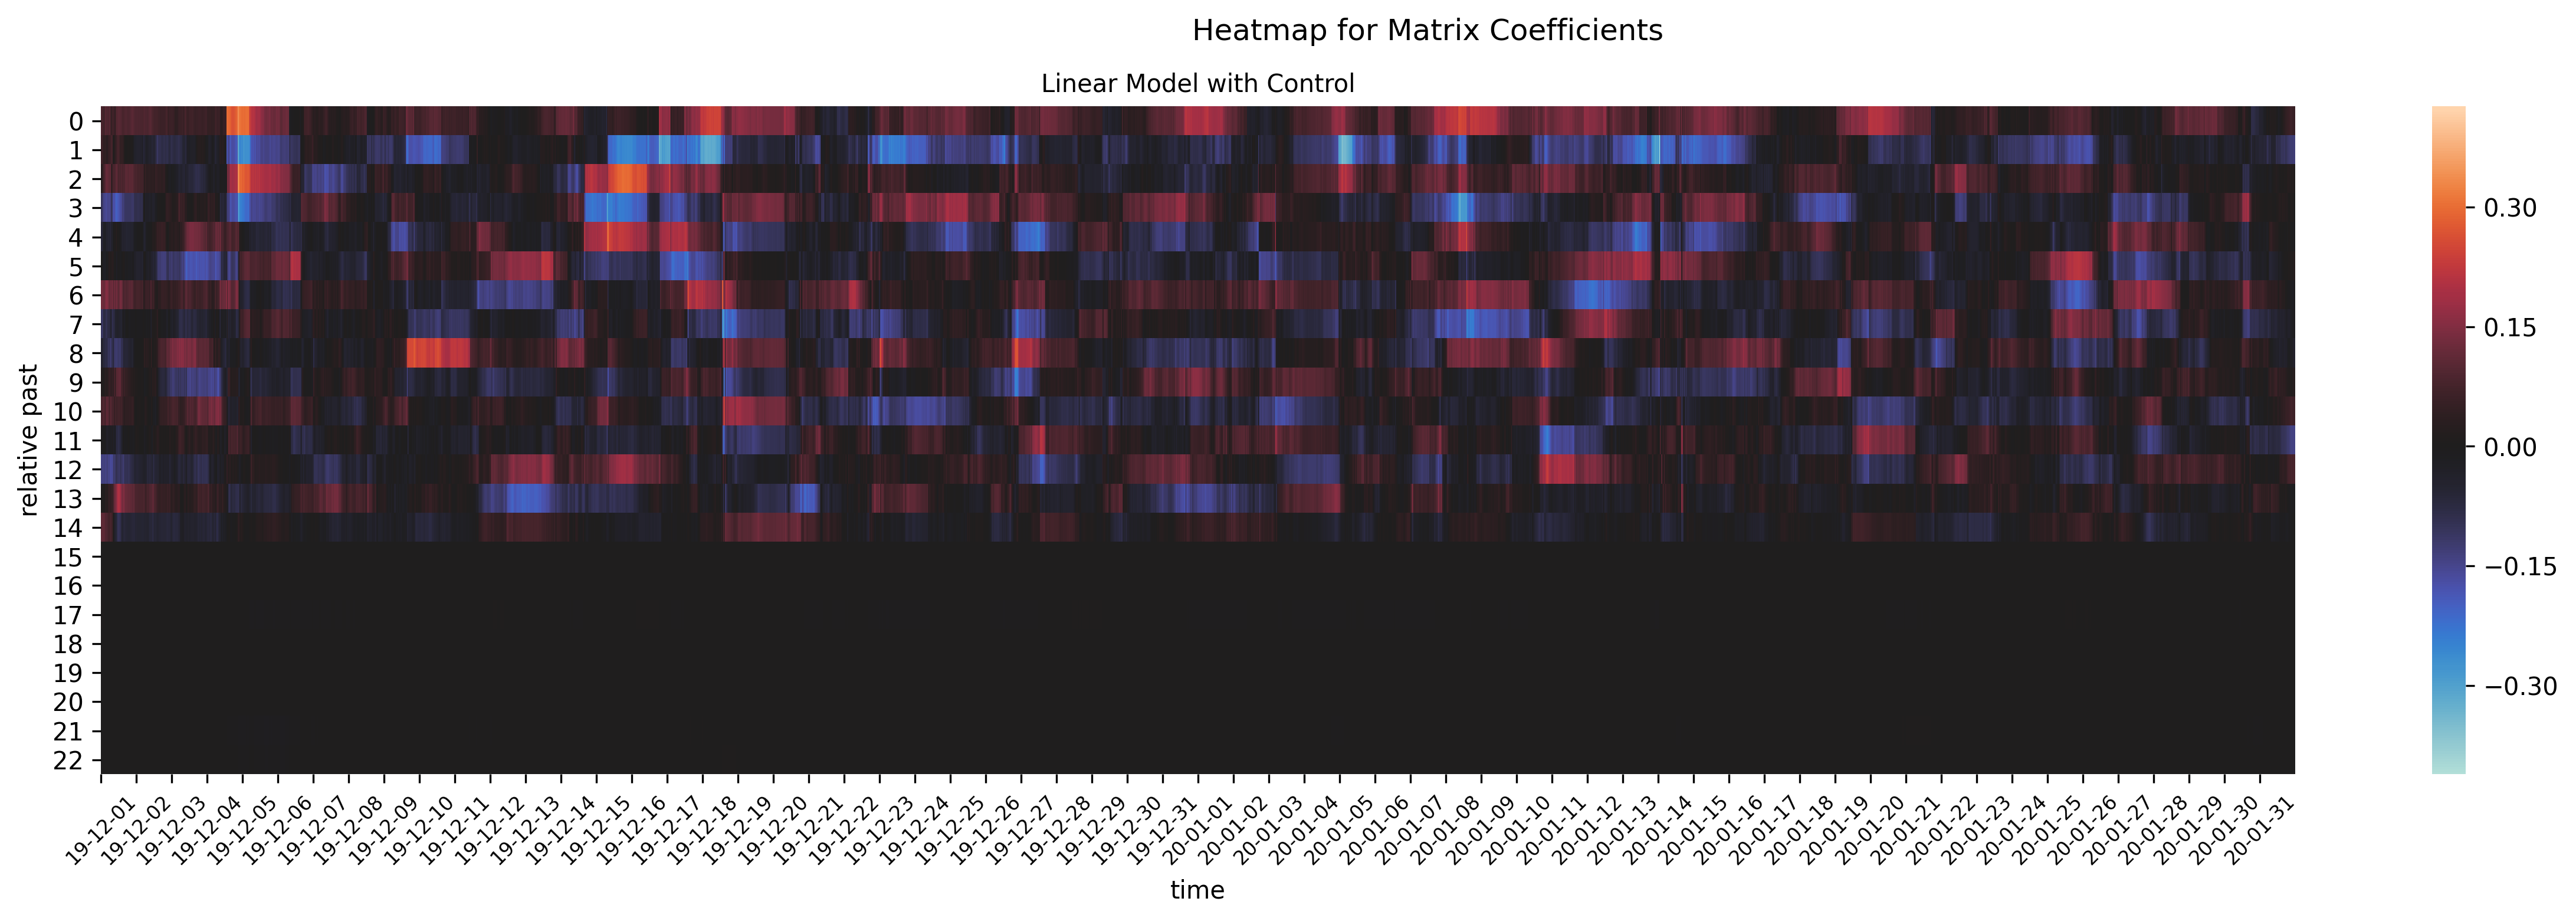

In [23]:
plot_heatmap(results[[f'{i}' for i in range(m+s+1)]], title)

# Weighted Linear Model with Control

In [3]:
features = compute_features(df)
s = len(features.columns)
features

,taker buy volume ratio,volume (1e3),volume change,trades number (1e3),trades number change,taker buy average spread (1e-3),taker sell average spread (1e-3)
2019-11-27 00:00:00,0.631978,0.164200,NaN,1.234,NaN,0.095183,-0.163451
2019-11-27 00:05:00,0.635365,0.115532,-0.296398,0.904,-0.267423,0.054070,-0.094216
2019-11-27 00:10:00,0.507273,0.112780,-0.023816,0.914,0.011062,0.124325,-0.127995
2019-11-27 00:15:00,0.446718,0.157904,0.400103,0.833,-0.088621,-0.002534,0.002046
2019-11-27 00:20:00,0.585600,0.071999,-0.544030,0.638,-0.234094,0.056861,-0.080352
...,...,...,...,...,...,...,...
2020-02-03 23:35:00,0.557644,0.148544,1.582849,1.348,0.829037,0.037126,-0.046801
2020-02-03 23:40:00,0.713958,0.090221,-0.392631,0.908,-0.326409,-0.008885,0.022178
2020-02-03 23:45:00,0.486972,0.139876,0.550373,1.874,1.063877,0.046432,-0.044074
2020-02-03 23:50:00,0.475670,0.095825,-0.314930,1.331,-0.289755,-0.005927,0.005377


In [128]:
# alpha_inv = 99, 98, 97, 96, 95, 94, 93, 92, 91
alpha_inv = 104
title, k, m = f'Weighted ({alpha_inv:02d}%) Linear Model with Control', 511, 15
# for alpha_inv  in range(102, 104): 
#     title, k, m = f'Weighted ({alpha_inv:02d}%) Linear Model with Control', 511, 15
#     calculate_thetas(df, title, k, m, alpha_inv=alpha_inv, features=features)

In [129]:
# tmp_ = [[], [], []]
# for alpha_inv in range(91, 104):
#     title = f'Weighted ({alpha_inv:02d}%) Linear Model with Control'
#     if alpha_inv == 100:
#         title = 'Linear Model with Control'
#     results = load_results(title, k, m, alpha_inv)
#     tmp = np.sign(results['Prediction']) == np.sign(results['Reality'])
#     tmp_[0].append(alpha_inv)
#     tmp_[1].append((results['Prediction'] - results['Reality']).std())
#     tmp_[2].append((np.count_nonzero(tmp)/len(tmp) - 0.5))
# tmp_[0] = np.array(tmp_[0])
    
# plt.plot(tmp_[0]/100, tmp_[1], label='noise std')
# plt.plot(tmp_[0]/100, tmp_[2], label='accuracy - 0.5')
# plt.xlabel('alpha inverse')
# plt.ylabel('value')
# plt.title('Comparison of time sensitivity values')
# plt.legend()
# plt.axhline(0, linestyle=':', color='black')
# plt.savefig('plots/alpha comparison.png')
# plt.show()

In [130]:
results = load_results(title, k, m, alpha_inv)
results

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\Torobcheh\\Desktop\\CVX\\cvx_project_Kalman_Filter/data/Weighted (104%) Linear Model with Control[k=00511,m=00015,a=0.962].csv'

In [131]:
apply_kalman_filter(results)
results

,Prediction,Measurement,Model Noise Bias,Reality,0,1,2,3,4,5,...,20,21,22,Measurement Residual,Prediction Residual,Measurement Residual Weighted Variance,Prediction Residual Weighted Variance,Kalman Gain,Estimate,Estimate Uncertainty
2019-12-01 00:00:00,-0.000671,-0.000246,0.000072,-0.001031,0.197922,-0.119462,0.036770,0.037251,0.002061,-0.092967,...,-0.000112,-0.002994,-0.002639,0.000785,0.000360,NaN,NaN,NaN,NaN,NaN
2019-12-01 00:05:00,-0.000149,-0.000688,0.000123,-0.002840,0.201758,-0.140409,0.004441,0.053156,-0.017294,-0.047632,...,-0.000016,0.001965,0.001194,0.002152,0.002691,NaN,NaN,NaN,NaN,NaN
2019-12-01 00:10:00,0.000179,-0.000605,0.000195,-0.000342,0.161252,-0.155625,0.027026,0.010139,0.010347,-0.069827,...,0.000003,0.000900,0.000100,-0.000263,0.000522,NaN,NaN,NaN,NaN,NaN
2019-12-01 00:15:00,0.001007,0.000014,0.000277,-0.001469,0.082387,-0.119951,0.020356,0.017428,-0.060153,0.010243,...,-0.000007,-0.002033,-0.001584,0.001483,0.002477,NaN,NaN,NaN,NaN,NaN
2019-12-01 00:20:00,-0.000042,-0.001108,0.000243,-0.000018,0.115350,-0.148436,0.049436,-0.013434,-0.041441,0.057967,...,0.000260,-0.000391,-0.000086,-0.001090,-0.000024,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-31 23:35:00,0.000567,0.001077,-0.000058,0.000035,-0.124530,-0.117258,0.070677,-0.026531,-0.076137,0.052136,...,0.001119,-0.000597,0.000580,0.001042,0.000531,0.000001,0.000001,0.468393,0.000806,6.143658e-07
2020-01-31 23:40:00,0.000985,0.000342,-0.000016,-0.003235,-0.053983,0.028281,-0.055561,-0.018187,-0.103680,0.110942,...,0.001959,0.001620,0.002640,0.003577,0.004219,0.000001,0.000002,0.566804,0.000621,8.491481e-07
2020-01-31 23:45:00,0.000150,-0.000170,-0.000009,-0.001554,-0.054032,0.027734,-0.055921,-0.018210,-0.102977,0.111366,...,0.001965,0.001620,0.002631,0.001383,0.001704,0.000002,0.000002,0.559524,-0.000029,8.516512e-07
2020-01-31 23:50:00,0.001328,-0.000945,-0.000004,0.000073,-0.047435,-0.051929,0.085864,-0.003133,-0.111831,0.076565,...,0.002312,0.001738,0.003217,-0.001019,0.001255,0.000002,0.000002,0.558409,0.000059,8.575437e-07


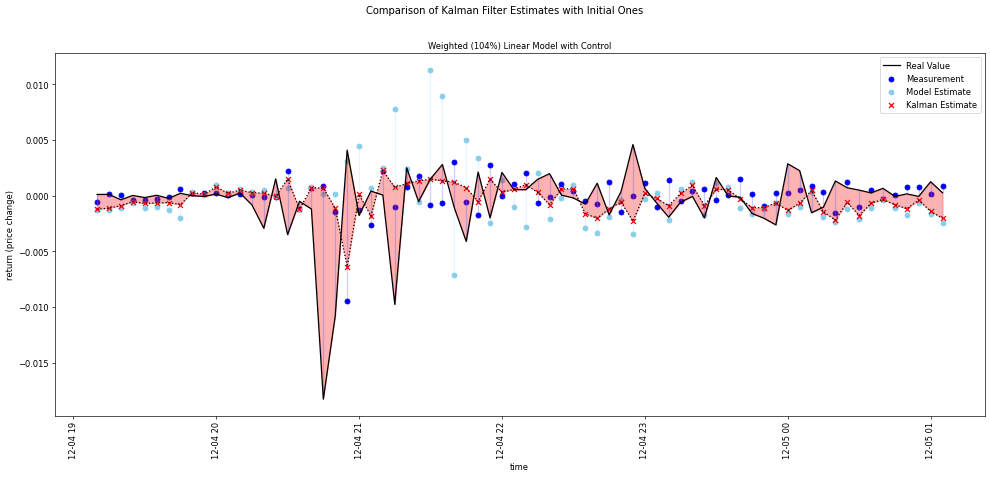

In [132]:
indices = results.index[np.arange(12*6) + int(288*3.8)]
plot_returns_and_filter(results, indices, title)

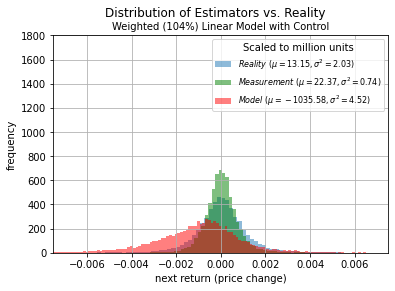

In [133]:
plot_estimators_hist(results, title, limits=None)

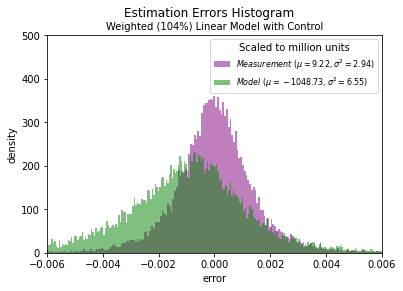

In [134]:
plot_errors_hist(results, title)

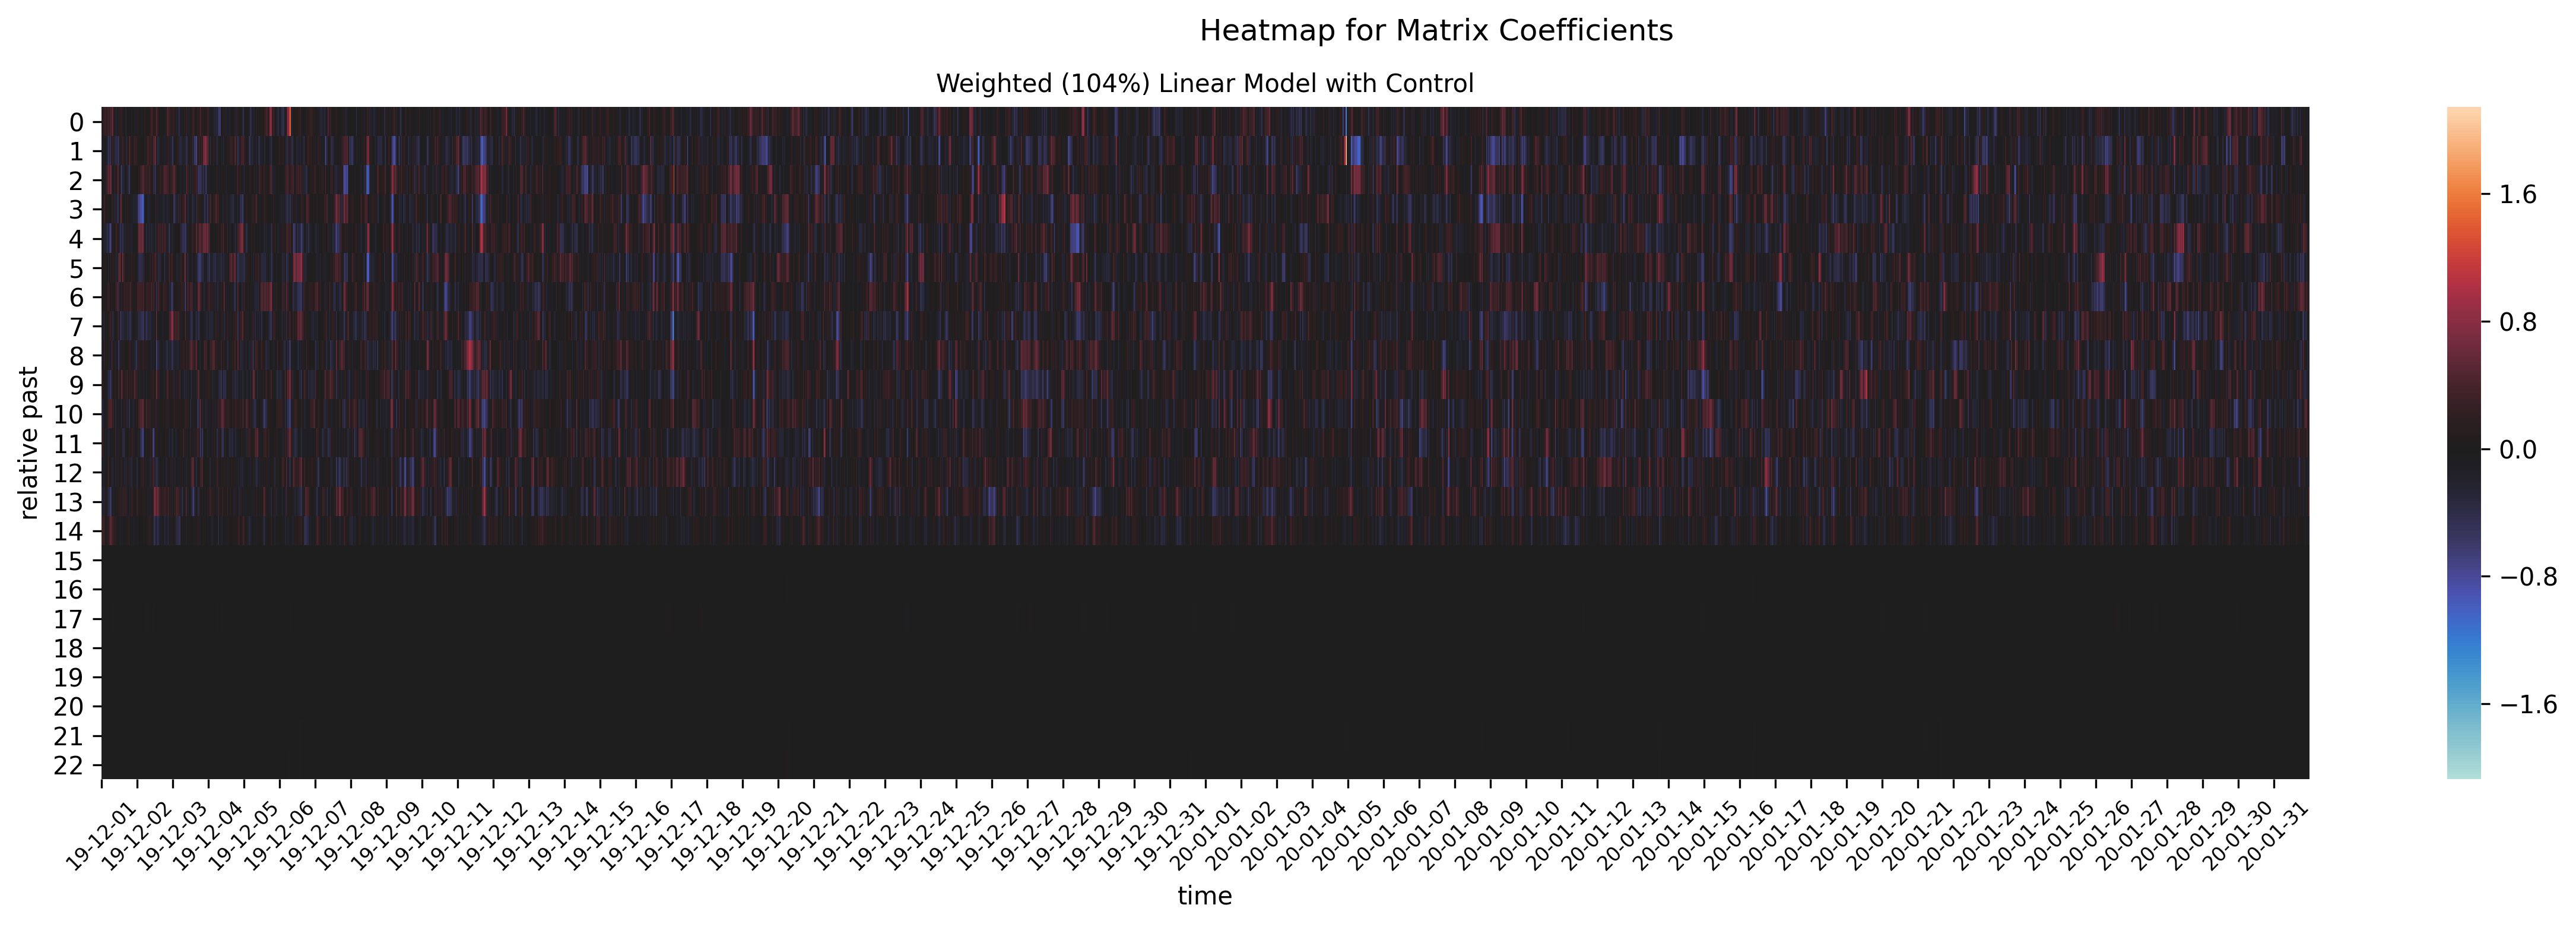

In [135]:
plot_heatmap(results[[f'{i}' for i in range(m+s+1)]], title)

# Linear Dense Model with control

# Feature Processing

In [182]:
from scipy.stats import pearsonr
special_indices = features[(features['volume (1e3)'] > 0.0) & (features['volume change'] > -100)].index
special_indices = list(sorted(list(set(special_indices).intersection(set(results.index)))))
len(special_indices)

17856

In [198]:
df_ = load_data(start_time_, end_time_)
timeframe = timedelta(minutes=1)
df = resample_data(df_, timeframe, start_time_, end_time_)
df

,Open,High,Low,Close,Volume,Value,No. Trades,Taker Buy Volume,Taker Buy Value,Average Price,Average Price Change
2019-11-27 00:00:00,7154.75,7157.17,7140.93,7143.75,50.602090,361769.135911,385,25.821743,184606.826394,7149.292369,NaN
2019-11-27 00:01:00,7143.68,7147.86,7140.54,7145.65,23.730561,169533.383641,222,16.156826,115429.347803,7144.095061,-0.000727
2019-11-27 00:02:00,7144.64,7153.89,7144.63,7151.6,19.483032,139284.673628,180,14.570335,104167.055035,7149.024527,0.000690
2019-11-27 00:03:00,7152.05,7153.89,7148.79,7151.31,24.308410,173835.703832,157,9.768423,69859.228982,7151.257685,0.000312
2019-11-27 00:04:00,7152.07,7164.59,7150.99,7162.89,46.076171,329899.961909,290,37.453687,268154.818917,7159.882316,0.001206
...,...,...,...,...,...,...,...,...,...,...,...
2020-02-03 23:55:00,9307.21,9307.73,9299.21,9299.22,21.421539,199333.709068,222,9.042252,84149.166180,9305.293568,-0.000261
2020-02-03 23:56:00,9299.28,9305.88,9298.32,9303.07,22.548824,209730.383157,205,17.150674,159517.416949,9301.167243,-0.000443
2020-02-03 23:57:00,9303.1,9303.58,9300.04,9301.45,13.845829,128797.438535,218,5.103780,47477.145602,9302.255469,0.000117
2020-02-03 23:58:00,9302.13,9307.02,9301.28,9303.42,13.548862,126055.889250,183,8.918618,82976.801269,9303.799039,0.000166


In [199]:
features = compute_features(df)
s = len(features.columns)
features

,taker buy volume ratio,volume (1e3),volume change,trades number (1e3),trades number change,taker buy average spread (1e-3),taker sell average spread (1e-3)
2019-11-27 00:00:00,0.510290,0.050602,NaN,0.385,NaN,-0.001971,0.002053
2019-11-27 00:01:00,0.680845,0.023731,-0.531036,0.222,-0.423377,0.029863,-0.063706
2019-11-27 00:02:00,0.747847,0.019483,-0.178990,0.180,-0.189189,0.032379,-0.096032
2019-11-27 00:03:00,0.401854,0.024308,0.247671,0.157,-0.127778,0.038922,-0.026149
2019-11-27 00:04:00,0.812865,0.046076,0.895483,0.290,0.847134,-0.034204,0.148573
...,...,...,...,...,...,...,...
2020-02-03 23:55:00,0.422110,0.021422,1.132842,0.222,0.321429,0.099319,-0.072546
2020-02-03 23:56:00,0.760602,0.022549,0.052624,0.205,-0.076577,-0.024262,0.077083
2020-02-03 23:57:00,0.368615,0.013846,-0.385962,0.218,0.063415,0.010114,-0.005905
2020-02-03 23:58:00,0.658256,0.013549,-0.021448,0.183,-0.160550,-0.002751,0.005300


In [215]:
correlations_1 = {}
c = 'taker buy volume ratio'
for vc in np.arange(0, 500, 50):
    correlations_1[vc] = []
    for t in range(20):
        future_returns = df['Average Price'].shift(-t-1) / df['Average Price'] - 1
        common_indices = set(future_returns.dropna().index).intersection(features[c].dropna().index)
        common_indices = features.loc[common_indices][features.loc[common_indices, 'volume change'] >= vc/100].index
        correlations_1[vc].append(pearsonr(future_returns.loc[common_indices], features.loc[common_indices, c])[0])
correlations_1

{0: [0.21481971623009644,
  0.1404621599927851,
  0.11026718901490437,
  0.09105067127357884,
  0.0741952588621999,
  0.06269753584003197,
  0.05209573954127207,
  0.04371328933237972,
  0.03717763611243073,
  0.03369581319766552,
  0.03275487943634257,
  0.031929794687623254,
  0.03072070240158757,
  0.03050169183222171,
  0.031168727831469192,
  0.031038627409249786,
  0.029319241160756626,
  0.027619639765087863,
  0.028828582286856457,
  0.02819474480471059],
 50: [0.23815508115139009,
  0.15885483185943805,
  0.12402335464266706,
  0.10432120036493138,
  0.08535778823284465,
  0.07395820217940612,
  0.06363668396986376,
  0.05418949743445298,
  0.048497159353508165,
  0.042091474939480504,
  0.039758021304418995,
  0.03780779188511081,
  0.03532617965859225,
  0.03565312154371143,
  0.03531640411453959,
  0.03462192126314213,
  0.03340892314234645,
  0.030814101468157568,
  0.03180780231425173,
  0.03219326469078692],
 100: [0.25069380486340054,
  0.17215399412380694,
  0.13806599

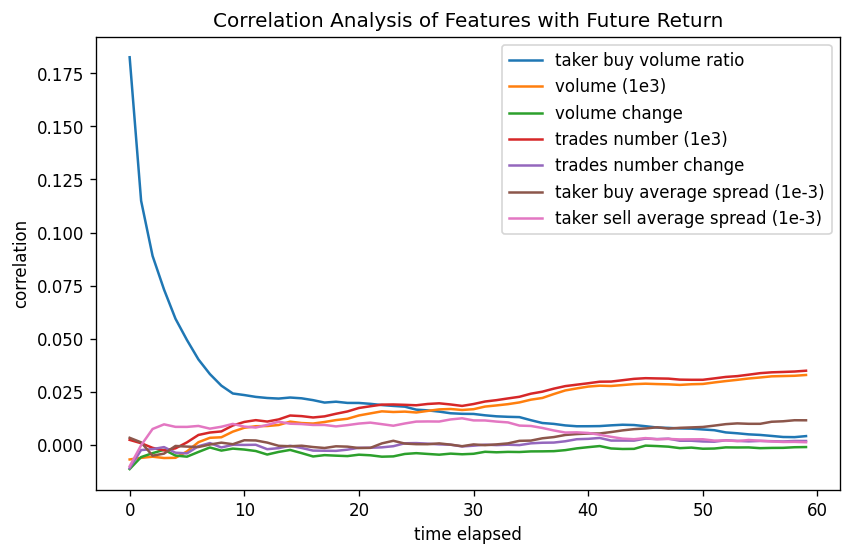

In [196]:
plt.figure(figsize=(8, 5), dpi=120)
for c in correlations.keys():
    plt.plot(correlations[c], label=c)
plt.legend()
plt.title('Correlation Analysis of Features with Future Return')
plt.ylabel('correlation')
plt.xlabel('time elapsed')
plt.show()

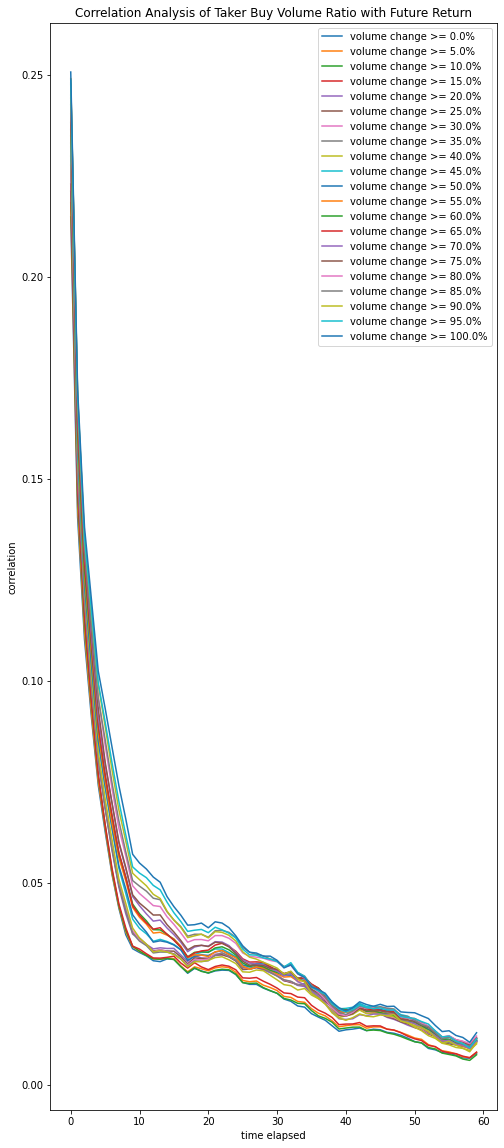

In [214]:
plt.figure(figsize=(8, 20))#, dpi=120)
for c in correlations_.keys():
    plt.plot((np.array(correlations_[c])), label=f'volume change >= {c/2}%')
plt.legend()
plt.title('Correlation Analysis of Taker Buy Volume Ratio with Future Return')
plt.ylabel('correlation')
plt.xlabel('time elapsed')

plt.show()

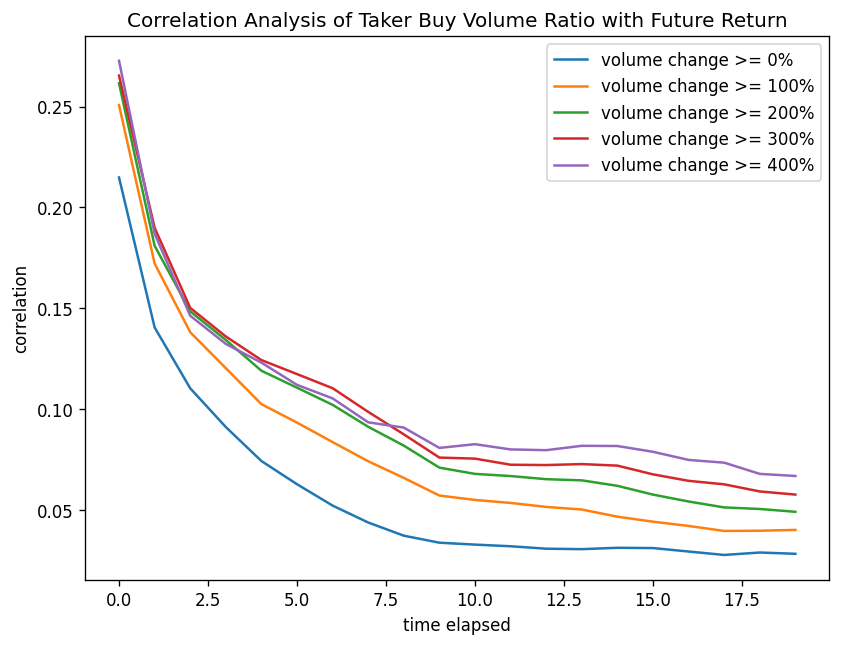

In [220]:
plt.figure(figsize=(8, 6), dpi=120)
for c in correlations_1.keys():
    if c % 100 == 0:
        plt.plot((np.array(correlations_1[c])), label=f'volume change >= {c}%')
plt.legend()
plt.title('Correlation Analysis of Taker Buy Volume Ratio with Future Return')
plt.ylabel('correlation')
plt.xlabel('time elapsed')

plt.show()